In [34]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.activations import relu, tanh, softmax, sigmoid
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout, PReLU, LeakyReLU, Input, BatchNormalization, Activation, Flatten


In [ ]:
# np.set_printoptions(threshold=sys.maxsize)

In [35]:
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [36]:
with open('../colume_pickle/test_complete_df_6개월_choice_10개_대형주.pkl', 'rb') as f:
    stock_df = pickle.load(f)
with open('../colume_pickle/6개월_choice_10개_cor_0.075_lstm_대형주.pkl', 'rb') as f:
    col_list = pickle.load(f)

In [37]:
stock_df['pct_label'].value_counts()

0.0     103626
0.2      52866
0.3      39303
0.1      38075
0.5      35965
         ...  
20.1         1
19.5         1
20.8         1
15.9         1
21.9         1
Name: pct_label, Length: 191, dtype: int64

In [38]:
# col_list = col_list.drop('날짜')

In [39]:
col_list

시간                         -0.306454
시가                         -0.067072
고가                         -0.066999
저가                         -0.067114
종가                         -0.067027
누적체결매수수량                   -0.105825
누적체결매도수량                   -0.109951
전일대비                        0.221439
상장주식수                      -0.120217
시가총액                       -0.142092
외국인현보유비율                   -0.096250
기관누적순매수량                    0.110315
AUDKRW내역_거래량                0.076446
CADKRW내역_거래량                0.075311
CBOEVolatilityIndex내역_종가    0.078165
CBOEVolatilityIndex내역_저가    0.078928
DowJonesShanghai내역_변동       0.075500
FTSEChinaA50내역_변동           0.081399
INRKRW내역_변동                -0.079489
NZDKRW내역_종가                -0.086069
NZDKRW내역_고가                -0.076379
NZDKRW내역_저가                -0.079247
PSI내역_거래량                   0.088421
SETIndex내역_변동               0.083096
SP500내역_종가                 -0.076211
닛케이내역_오픈                   -0.084876
닛케이내역_고가                   -0.078780
닛

In [40]:
cate = pd.DataFrame({'pct_label' : [0,1]})

ohe = OneHotEncoder(sparse=False)
ohe_test = ohe.fit_transform(cate[['pct_label']])
# ohe.categories_
len(ohe_test[0])
# pd.DataFrame(ohe_test, columns=['pct_label_' + str(col) for col in ohe.categories_[0]])

2

In [41]:
stock_df['pct_label'] = stock_df['pct_label'].apply(np.floor)
stock_df['pct_label']

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
52573    0.0
52574    0.0
52575    0.0
52576    0.0
52577    0.0
Name: pct_label, Length: 525780, dtype: float64

In [42]:
stock_df[stock_df['pct_label'] > 0] = 1

In [43]:
y_stock_df = stock_df['pct_label']

In [44]:
y_stock_df.shape

(525780,)

In [45]:
y_stock_df = ohe.transform(stock_df[['pct_label']])
y_stock_df.shape

(525780, 2)

In [46]:
stock_df

,날짜,시간,시가,고가,저가,종가,거래량,거래대금,누적체결매수수량,누적체결매도수량,...,헝가리BUX내역_고가,헝가리BUX내역_저가,헝가리BUX내역_거래량,헝가리BUX내역_변동,호주SPASX내역_종가,호주SPASX내역_오픈,호주SPASX내역_고가,호주SPASX내역_저가,호주SPASX내역_거래량,호주SPASX내역_변동
0,1,1,1.0,1.0,1.0,1.0,1.0,1.000000e+00,1.0,1.0,...,1.00,1.00,1,1.00,1.0,1.0,1.0,1.0,1.0,1.00
1,1,1,1.0,1.0,1.0,1.0,1.0,1.000000e+00,1.0,1.0,...,1.00,1.00,1,1.00,1.0,1.0,1.0,1.0,1.0,1.00
2,1,1,1.0,1.0,1.0,1.0,1.0,1.000000e+00,1.0,1.0,...,1.00,1.00,1,1.00,1.0,1.0,1.0,1.0,1.0,1.00
3,1,1,1.0,1.0,1.0,1.0,1.0,1.000000e+00,1.0,1.0,...,1.00,1.00,1,1.00,1.0,1.0,1.0,1.0,1.0,1.00
4,1,1,1.0,1.0,1.0,1.0,1.0,1.000000e+00,1.0,1.0,...,1.00,1.00,1,1.00,1.0,1.0,1.0,1.0,1.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52573,20221121,1517,35400.0,35450.0,35400.0,35450.0,2496.0,8.836100e+07,190577.0,253355.0,...,44778.83,44034.23,0,0.22,7139.3,7151.8,7174.4,7131.7,598630000.0,-0.17
52574,20221121,1518,35450.0,35450.0,35400.0,35450.0,1130.0,4.003700e+07,191269.0,253793.0,...,44778.83,44034.23,0,0.22,7139.3,7151.8,7174.4,7131.7,598630000.0,-0.17
52575,20221121,1519,35400.0,35450.0,35400.0,35450.0,2607.0,9.236600e+07,192828.0,254841.0,...,44778.83,44034.23,0,0.22,7139.3,7151.8,7174.4,7131.7,598630000.0,-0.17
52576,20221121,1520,35400.0,35450.0,35400.0,35450.0,2194.0,7.774400e+07,194375.0,255488.0,...,44778.83,44034.23,0,0.22,7139.3,7151.8,7174.4,7131.7,598630000.0,-0.17


In [47]:
col_list = list(col_list.index)
X_stock_df = stock_df.drop(['pct_label'],axis=1)
X_stock_df = X_stock_df.set_index(['날짜'])
X_stock_df = X_stock_df[col_list]

X_stock_df

,시간,시가,고가,저가,종가,누적체결매수수량,누적체결매도수량,전일대비,상장주식수,시가총액,...,닛케이내역_저가,다우존스내역_종가,러셀2000지수내역_종가,러셀2000지수내역_오픈,러셀2000지수내역_고가,코스닥내역_변동,코스피50내역_거래량,코스피50내역_변동,코스피지수내역_변동,헝가리BUX내역_오픈
날짜,,,,,,,,,,,,,,,,,,,,,
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1,1,1,...,1.0,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1,1,1,...,1.0,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1,1,1,...,1.0,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1,1,1,...,1.0,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1,1,1,...,1.0,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20221121,1517,35400.0,35450.0,35400.0,35450.0,190577.0,253355.0,-800,106903000,3784366000000,...,27846.3,33700.87,1836.51,1842.96,1842.96,-1.82,37070000.0,-0.79,-1.02,44496.51
20221121,1518,35450.0,35450.0,35400.0,35450.0,191269.0,253793.0,-800,106903000,3784366000000,...,27846.3,33700.87,1836.51,1842.96,1842.96,-1.82,37070000.0,-0.79,-1.02,44496.51
20221121,1519,35400.0,35450.0,35400.0,35450.0,192828.0,254841.0,-800,106903000,3784366000000,...,27846.3,33700.87,1836.51,1842.96,1842.96,-1.82,37070000.0,-0.79,-1.02,44496.51


In [48]:
X_stock_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 525780 entries, 1 to 20221121
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   시간                        525780 non-null  int64  
 1   시가                        525780 non-null  float64
 2   고가                        525780 non-null  float64
 3   저가                        525780 non-null  float64
 4   종가                        525780 non-null  float64
 5   누적체결매수수량                  525780 non-null  float64
 6   누적체결매도수량                  525780 non-null  float64
 7   전일대비                      525780 non-null  int64  
 8   상장주식수                     525780 non-null  int64  
 9   시가총액                      525780 non-null  int64  
 10  외국인현보유비율                  525780 non-null  float64
 11  기관누적순매수량                  525780 non-null  int64  
 12  AUDKRW내역_거래량              525780 non-null  int64  
 13  CADKRW내역_거래량              525780 non-null 

In [49]:
# X_stock_df.drop('터키5년채권수익율내역_종가')
list(X_stock_df.isnull().sum())

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [50]:
X_stock_df.shape[1]

37

In [51]:
min_max_scaler = MaxAbsScaler()
X_stock_sc = min_max_scaler.fit_transform(X_stock_df)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_stock_sc, y_stock_df, test_size=0.3, random_state=42,stratify=y_stock_df)

In [53]:
X_train = X_train.reshape(X_train.shape[0], X_stock_df.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_stock_df.shape[1], 1)
print('훈련 데이터의 크기 :', X_train.shape, y_train.shape)
print('테스트 데이터의 크기 :', X_test.shape, y_test.shape)

훈련 데이터의 크기 : (368046, 37, 1) (368046, 2)
테스트 데이터의 크기 : (157734, 37, 1) (157734, 2)


In [59]:
inputs = Input(shape=(X_stock_df.shape[1], 1))
lstm_out = LSTM(16, dropout=0.2,return_sequences=True, kernel_initializer='random_normal')(inputs)
# return_sequences=True,
lstm_out = BatchNormalization()(lstm_out)
lstm_out = Activation('PReLU')(lstm_out)
lstm_out = LSTM(16, dropout=0.2, kernel_initializer='random_normal')(lstm_out)
lstm_out = BatchNormalization()(lstm_out)
lstm_out = Activation('PReLU')(lstm_out)
lstm_out = Dense(2)(lstm_out)
lstm_out = BatchNormalization()(lstm_out)
lstm_out = Activation('softmax')(lstm_out) 



early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
# 모델의 이름을 정합니다.
#                   모델명_ep_bs_pa_lr_cor
modelpath="./model/lstm_100_128_10_0.0000001_0.075_대형주_범위(0,1).hdf5"

# 최적화 모델을 업데이트하고 저장합니다.
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

model = Model(inputs=inputs, outputs=lstm_out)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0000001, decay=1e-7), metrics=['accuracy'])

history=model.fit(X_train, y_train, epochs=30, batch_size=128,verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping_callback, checkpointer])


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 37, 1)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 37, 16)            1152      
                                                                 
 batch_normalization_9 (Batc  (None, 37, 16)           64        
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 37, 16)            592       
                                                                 
 lstm_7 (LSTM)               (None, 16)                2112      
                                                                 
 batch_normalization_10 (Bat  (None, 16)               64        
 chNormalization)                                          

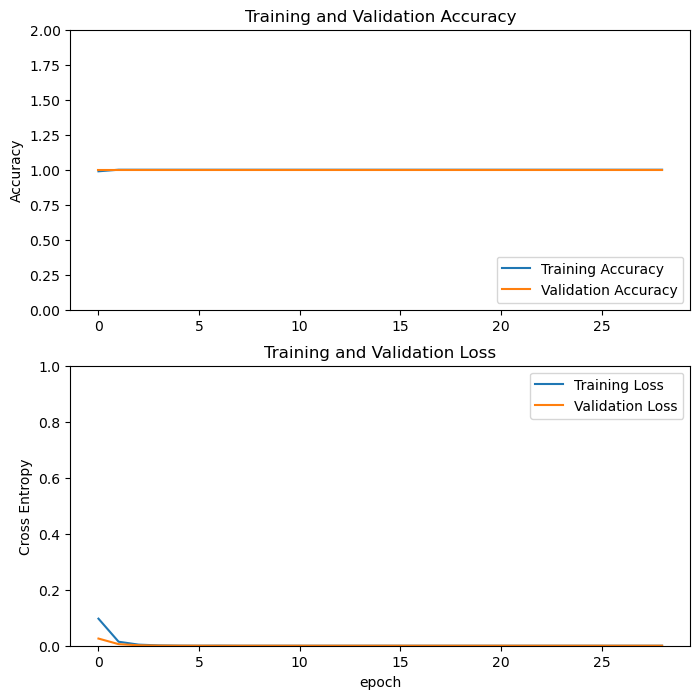

In [58]:
#Plotting
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,2])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [79]:
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

4930/4930 [==============================] - 25s 5ms/step - loss: 0.2288 - accuracy: 1.0000

 Test Accuracy: 1.0000


In [63]:
from keras.models import load_model
model_pred = load_model(modelpath)

In [64]:
with open('../colume_pickle/test_complete_df_6개월_choice_10개_대형주_update.pkl', 'rb') as f:
    pred_df = pickle.load(f)

In [65]:
pred_df['pct_label'] = pred_df['pct_label'].apply(np.floor)

In [66]:
pred_df[pred_df['pct_label'] > 0] = 1

In [67]:
y_pred_df = ohe.transform(pred_df[['pct_label']])
y_pred_df.shape

(19050, 2)

In [68]:
# col_list = list(col_list.index)
X_pred_df = pred_df.drop(['pct_label'],axis=1)
X_pred_df = X_pred_df.set_index(['날짜'])
X_pred_df = X_pred_df[col_list]


In [69]:
def predict_stock(code, col_list):
    with open(f.'../colume_pickle/test_complete_df_6개월_choice_10개_대형주_update_{code}.pkl', 'rb') as f:
        pred_df = pickle.load(f)
    
    X_pred_df = pred_df.drop(['pct_label'],axis=1)
    X_pred_df = X_pred_df.set_index(['날짜'])
    X_pred_df = X_pred_df[col_list]
    
    X_pred_sc = min_max_scaler.fit_transform(X_pred_df)
    X_pred = X_pred_sc.reshape(X_pred_sc.shape[0], 37, 1)

    predict = model.predict(X_pred)
    
    return predict

(19050, 37, 1)

In [70]:
predict = model.predict(X_pred)

596/596 [==============================] - 3s 5ms/step


In [ ]:
# predict.value[0] < predict.value[1]    매수
# predict.value[0] > predict.value[1]    매도

In [ ]:
# sell 코드    buy 코드

In [ ]:
잔고 = 10000000
stock_list = []
for code in stock_list:

    predict = predict_stock(code, col_list)
    for x in len(predict):
        code의 맞는 데이터 프레임 = c
        종가 = c.loc[x,'종가'].value
        고가 = c.loc[x,'고가'].value
   
        종목당 매수금액 = 1000000
        num =0
        # num = 매수금액 / 종가
        if predict[x][0] < predict[x][1] and 현재 종가 <  현재 고가 and 종목당 매수금액 > 종가*buy_num:
            종목당 매수금액 = 종목당매수금액 - (종가*buy_num) # 매수
            num += buy_num
        elif predict[x][0] > predict.value[x][1] : 
            종목당 매수금액 = 종목당 매수금액 + (고가 * sell_num)
            num -= sell_num
        # else:
        #     hold

    잔고 = 잔고 + (종목당 매수금액 - 1000000)
#  잔고가 얼마냐? + 수익  - 손실

In [78]:
len(predict)#[0.6887641 , 0.31123596]

19050

In [ ]:
pred = tf.argmax(predict,1).numpy()
test = tf.argmax(y_pred_df,1).numpy()

In [ ]:
np.unique(pred,return_counts=True)

(array([0, 1], dtype=int64), array([16518,  2532], dtype=int64))

In [ ]:
np.unique(test,return_counts=True)

(array([0, 1], dtype=int64), array([16518,  2532], dtype=int64))

In [ ]:
acc = accuracy_score(test, pred)
print('accuracy_score : ',acc)

accuracy_score :  1.0


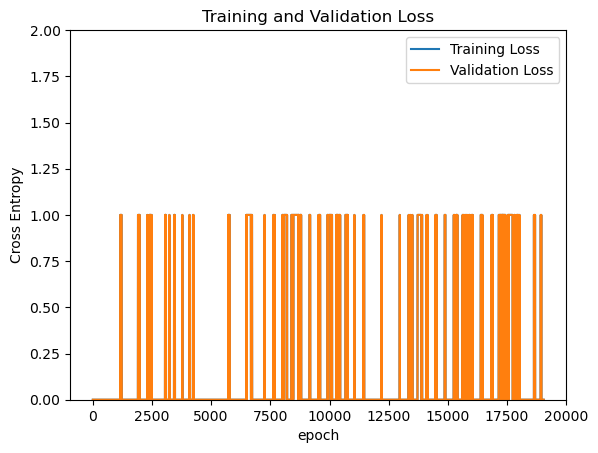

In [ ]:

plt.plot(test, label='Training Loss')
plt.plot(pred, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()